## Atmospheric River Detection QC

#### Setup:

In [5]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#import AR events shapefile
#ars_events = gpd.read_file("/atlas_scratch/jdpaul3/ar/outputs/landfall_ars_events.shp")

#import AR 6hr shapefile
gdf = gpd.read_file("/atlas_scratch/jdpaul3/ar/outputs/landfall_ars_6hr.shp")


In [7]:
gdf['time'] = pd.to_datetime(gdf['time'])

In [8]:
gdf

,index,time,label,ratio,length,orient,poleward,dir_coher,mean_dir,tot_str,rel_str,crit1,crit2,crit3,crit4,crit5,crit_cnt,geometry
0,3,1992-01-01 06:00:00,2.0,3.5,4854,33,221,87,358,2230418,488,1,1,1,1,1,5,"POLYGON ((-149.62500 61.12500, -149.37500 61.1..."
1,4,1992-01-01 12:00:00,4.0,4.2,3773,35,224,85,0,2233790,443,1,1,1,1,1,5,"POLYGON ((-143.12500 60.62500, -142.62500 60.6..."
2,21,1992-01-08 00:00:00,2.0,3.8,5254,25,232,81,360,3547765,569,1,1,1,1,1,5,"POLYGON ((-145.62500 60.62500, -145.12500 60.6..."
3,22,1992-01-08 06:00:00,2.0,3.7,4862,28,229,83,1,3182008,575,1,1,1,1,1,5,"POLYGON ((-135.87500 58.62500, -134.62500 58.6..."
4,24,1992-01-08 18:00:00,1.0,2.3,4606,22,249,77,1,3141921,530,1,1,1,1,1,5,"POLYGON ((-146.37500 60.62500, -142.37500 60.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10394,23723,2021-12-30 00:00:00,3.0,2.6,2986,31,228,74,355,2094112,428,1,1,1,1,1,5,"POLYGON ((-155.37500 59.12500, -150.37500 59.1..."
10395,23724,2021-12-30 06:00:00,2.0,2.2,2875,33,224,80,359,1907705,423,1,1,1,1,1,5,"POLYGON ((-154.62500 58.87500, -153.87500 58.8..."
10396,23727,2021-12-31 00:00:00,2.0,2.1,2712,31,210,86,360,1147189,384,1,1,1,1,1,5,"POLYGON ((-160.37500 60.87500, -159.37500 60.8..."
10397,23728,2021-12-31 06:00:00,4.0,2.7,2296,35,202,78,4,992145,359,1,1,1,1,1,5,"POLYGON ((-149.12500 59.37500, -147.87500 59.3..."


Text(0.5, 0.98, 'Landfall ARs: Monthly Count of AR Polygons (6hr timesteps)')

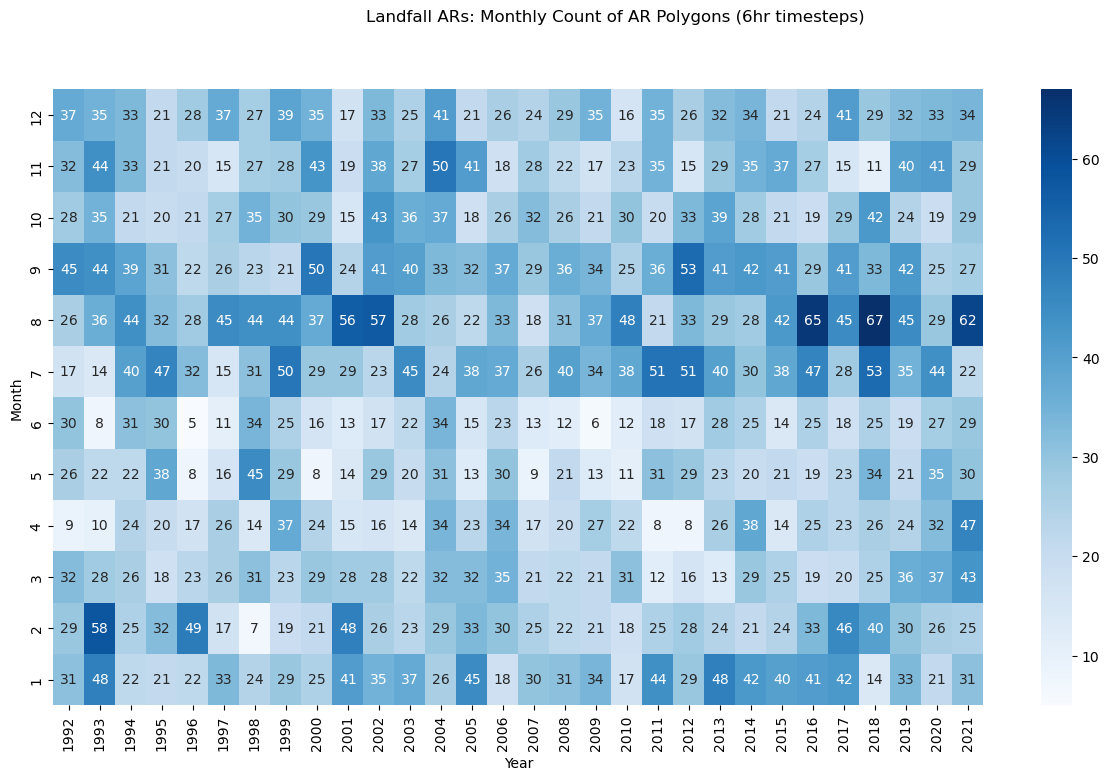

In [9]:
gdf["Year"] = gdf.time.apply(lambda x: x.year)
gdf["Month"] = gdf.time.apply(lambda x: x.month)
pt = gdf.pivot_table(index="Month",columns="Year",values="index", aggfunc="count").fillna(0)

fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(pt, annot=True, ax=ax, cmap='Blues')
ax.invert_yaxis()
fig.suptitle('Landfall ARs: Monthly Count of AR Polygons (6hr timesteps)')

Text(0.5, 0.98, 'Landfall ARs: Monthly Average of Relative Strength')

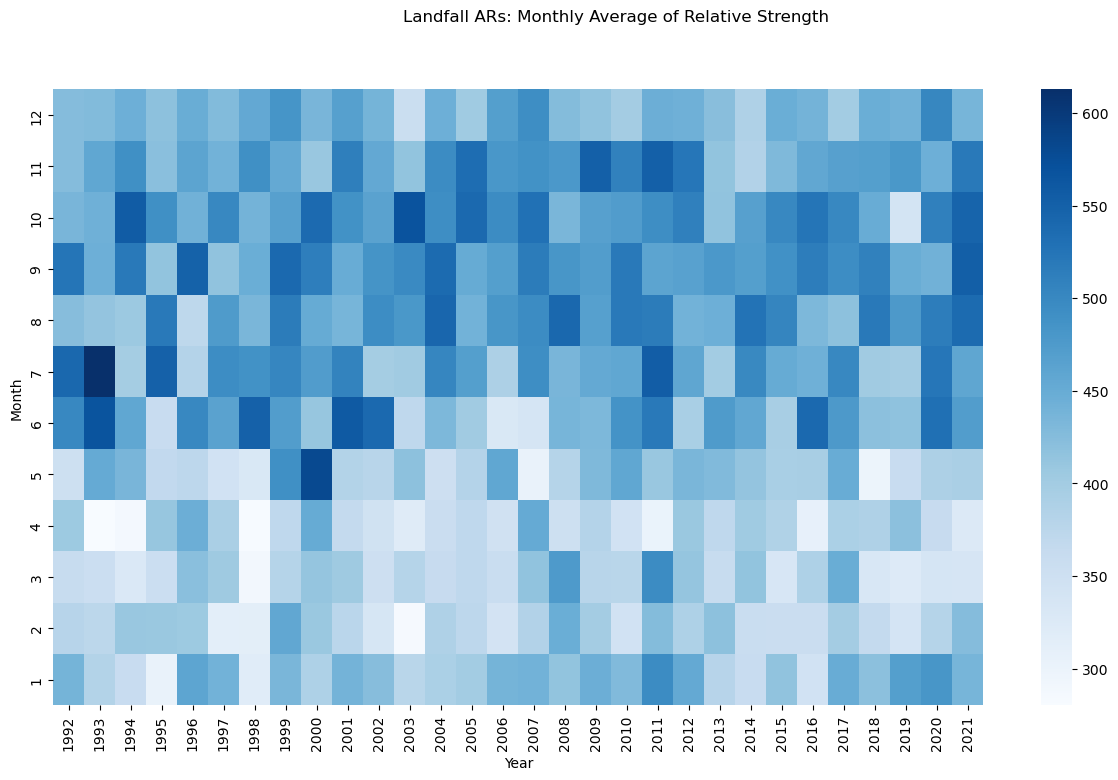

In [10]:
gdf["Year"] = gdf.time.apply(lambda x: x.year)
gdf["Month"] = gdf.time.apply(lambda x: x.month)
pt = gdf.pivot_table(index="Month",columns="Year",values="rel_str", aggfunc="mean").fillna(0)

fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(pt, annot=False, ax=ax, cmap='Blues')
ax.invert_yaxis()
fig.suptitle('Landfall ARs: Monthly Average of Relative Strength')

Text(0.5, 1.1, 'Pairplot of Landfall AR Properties')

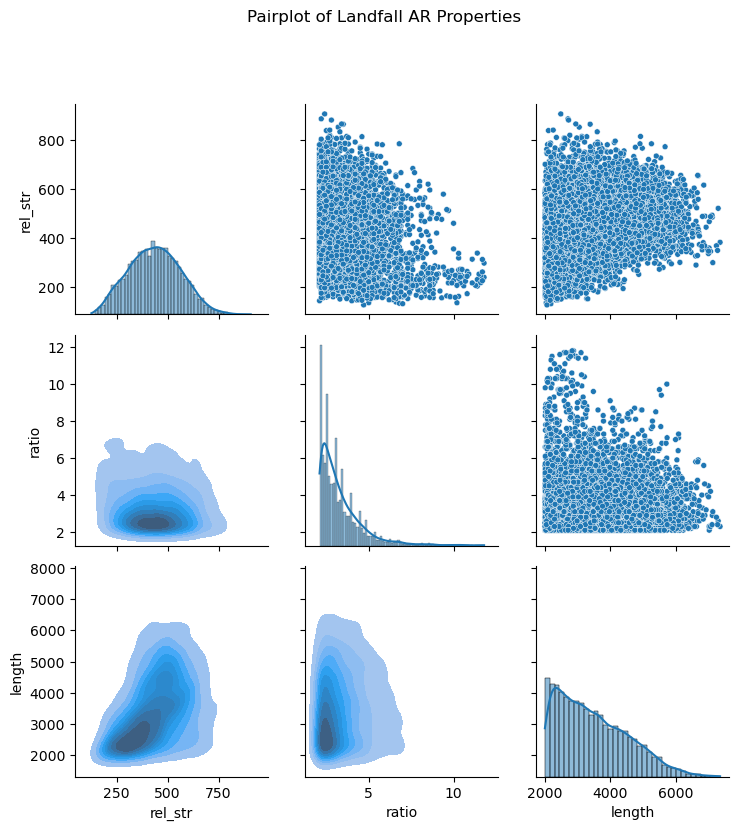

In [11]:
sub = gdf[['rel_str', 'ratio', 'length']]
sub = sub[sub['ratio'] < 12]

g = sns.PairGrid(sub)
g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

g.fig.suptitle('Pairplot of Select Landfall AR Properties', y=1.1)

In [12]:
gdf[gdf['ratio'] >12]

,index,time,label,ratio,length,orient,poleward,dir_coher,mean_dir,tot_str,rel_str,crit1,crit2,crit3,crit4,crit5,crit_cnt,geometry,Year,Month
476,1021,1993-04-01 18:00:00,1.0,12.7,2904,45,335,87,1,348915,175,1,1,1,1,1,5,"POLYGON ((-174.37500 64.37500, -171.62500 64.3...",1993,4
1257,2789,1995-07-19 12:00:00,2.0,20.0,2279,61,183,67,17,264279,207,1,1,1,1,1,5,"POLYGON ((-166.37500 66.12500, -119.87500 66.1...",1995,7
1555,3532,1996-07-21 18:00:00,1.0,17.5,2464,58,190,82,14,293726,209,1,1,1,1,1,5,"POLYGON ((-179.12500 66.12500, -125.62500 66.1...",1996,7
1556,3533,1996-07-22 00:00:00,1.0,18.0,2554,57,198,83,21,268096,198,1,1,1,1,1,5,"POLYGON ((-179.12500 66.12500, -125.62500 66.1...",1996,7
1860,4361,1997-08-17 00:00:00,1.0,14.3,2230,57,188,73,15,455546,221,1,1,1,1,1,5,"POLYGON ((-179.12500 66.12500, -148.37500 66.1...",1997,8
2819,6650,2000-06-26 12:00:00,1.0,20.7,2487,58,199,70,33,309101,210,1,1,1,1,1,5,"POLYGON ((-179.12500 66.12500, -161.12500 66.1...",2000,6
2820,6651,2000-06-26 18:00:00,1.0,23.7,2598,59,196,77,26,265343,204,1,1,1,1,1,5,"POLYGON ((-179.12500 66.12500, -127.12500 66.1...",2000,6
2821,6652,2000-06-27 00:00:00,1.0,27.8,3077,58,192,75,26,284330,194,1,1,1,1,1,5,"POLYGON ((-179.12500 66.12500, -122.87500 66.1...",2000,6
2822,6653,2000-06-27 06:00:00,1.0,33.1,3201,57,189,80,15,259014,206,1,1,1,1,1,5,"POLYGON ((-179.12500 66.12500, -119.87500 66.1...",2000,6
2823,6663,2000-07-04 12:00:00,1.0,22.2,2122,63,194,77,24,213019,207,1,1,1,1,1,5,"POLYGON ((-179.12500 66.12500, -132.87500 66.1...",2000,7


<Axes: >

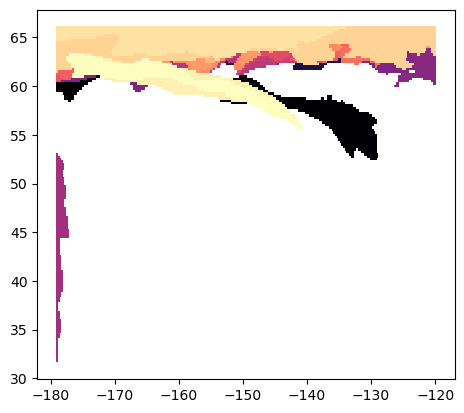

In [13]:
gdf[gdf['ratio'] >12].geometry.plot(cmap='magma')

index                                                     1021
time                                       1993-04-01 18:00:00
label                                                      1.0
ratio                                                     12.7
length                                                    2904
orient                                                      45
poleward                                                   335
dir_coher                                                   87
mean_dir                                                     1
tot_str                                                 348915
rel_str                                                    175
crit1                                                        1
crit2                                                        1
crit3                                                        1
crit4                                                        1
crit5                                                  

<Axes: >

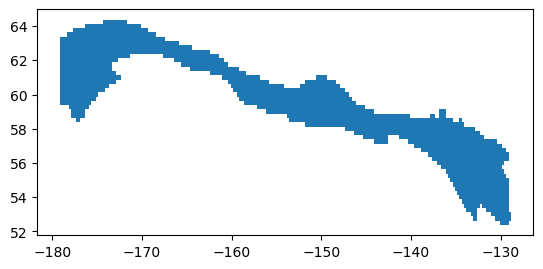

In [29]:
print(gdf[gdf['ratio'] >12].iloc[0])
gdf[gdf['ratio'] >12].iloc[[0]].geometry.plot()